In [1]:
import sys
PATH_TO_ROOT='D:/My Repository'
sys.path.insert(0, PATH_TO_ROOT)

In [2]:
import pandas as pd
import numpy as np
from AlphaMobileSensing import Msenseing

In [3]:
datapath='D:/Research Working Folder/Paper_1-Mobile Sensing Virtual Environment/dynamic_50cm_DEMO_new.csv'


env=Msenseing.AlphaMoSeEnv(datapath, 2500, 1, 15, (3.5, 3), 2, (0.5, 0.5), 500)

C:\Users\qizho\AppData\Roaming\Python\Python39\site-packages\gym\spaces\box.py:112: UserWarning: WARN: Box bound precision lowered by casting to float64
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [4]:
action_series_df=pd.read_excel('D:/Research Working Folder/Paper_1-Mobile Sensing Virtual Environment/action series for test.xlsx')

In [334]:
env.reset()


measurement_log=np.zeros(((len(action_series_df)+1),4))
measurement_log[0,:]=env.obs[:]

for i in range(len(action_series_df)):
    env.step(action_series_df.iloc[i,:].values)
    measurement_log[i+1,:]=env.obs[:]

Episode: 6
Total moving distance (m)
204.0
Total moving time (s)
1390.0


In [348]:
env.global_time

2005.0

In [316]:
from loess import loess_1d
from sklearn import linear_model
import matplotlib.pyplot as plt

In [336]:
x=measurement_log[:-1,0]
y=measurement_log[:-1,1]

t=measurement_log[:-1, 2]
v=measurement_log[:-1, 3]

fglobal=loess_1d.loess_1d(x=t,y=v, xnew=t)

In [337]:
r_i=v-fglobal[1]

In [338]:
r_i

array([ 1.72395505,  0.01258693,  0.23464283,  0.19583465,  0.19579212,
       -0.17226223, -0.17845427, -0.17745964, -0.34763811, -0.11183152,
       -0.0820154 , -0.11408412, -0.08447924, -0.14360268, -0.11634657,
       -0.18187748, -0.44341167, -0.07684918,  0.12824706, -0.14128015,
        0.31816998,  0.03779638,  0.19966234, -0.03821334,  0.06123926,
        0.02481227,  0.13552619, -0.12796538,  0.2279973 , -0.15997332,
       -0.53927582,  0.07743634, -0.29026442, -0.03215228, -0.20933166,
        0.10686603, -0.12828041, -0.00852361,  0.10764339, -0.06156944,
        0.21168225,  0.00595934])

In [339]:
nor_measurement_log=np.zeros((43,3))
for i in range(3):
    nor_measurement_log[:,i]=(measurement_log[:,i]-measurement_log[:,i].min())/(measurement_log[:,i].max()-measurement_log[:,i].min())

In [340]:
reg=linear_model.LinearRegression()
reg.fit(nor_measurement_log[:-1, 0:3], r_i)

LinearRegression()

In [341]:
reg.coef_

array([ 0.90547343, -0.28803773, -1.16728257])

In [342]:
reg.intercept_

0.23703245311802598

In [349]:
target_time=2005

xgrid=np.mgrid[-0.5:73.55:100j, -3:22.95:100j]
xflat = xgrid.reshape(2, -1).T
t_array=np.zeros((10000,1))+target_time
xflat=np.concatenate([xflat, t_array], axis=1)

nor_xflat=np.zeros((10000,3))
for i in range(3):
    nor_xflat[:,i]=(xflat[:,i]-measurement_log[:,i].min())/(measurement_log[:,i].max()-measurement_log[:,i].min())
    

fglobal=loess_1d.loess_1d(x=t,y=v, xnew=np.array([target_time]))

newz=fglobal[1]+reg.intercept_+reg.coef_[0]*nor_xflat[:,0]+reg.coef_[1]*nor_xflat[:,1]+reg.coef_[2]*nor_xflat[:,2]

In [350]:
data=env.stdata[['X', 'Y']]

delta=1.5

for i in range(10000):
    bb=xflat[i,:]
    judge_array=[0,0,0,0]
    window_data=data.loc[(data['X']>(bb[0]-delta)) & (data['X']<(bb[0]+delta)) & 
    (data['Y']>(bb[1]-delta)) & (data['Y']<(bb[1]+delta)), ['X', 'Y']]
    judge_array[0]=window_data.loc[(window_data['X']<bb[0]) & (window_data['Y']<bb[1])].empty
    judge_array[1]=window_data.loc[(window_data['X']<bb[0]) & (window_data['Y']>bb[1])].empty
    judge_array[2]=window_data.loc[(window_data['X']>bb[0]) & (window_data['Y']<bb[1])].empty
    judge_array[3]=window_data.loc[(window_data['X']>bb[0]) & (window_data['Y']>bb[1])].empty
    if True in judge_array:
        newz[i]=np.nan 


ygrid = newz.reshape(100, 100)

(-0.5, 73.55, -3.0, 22.95)

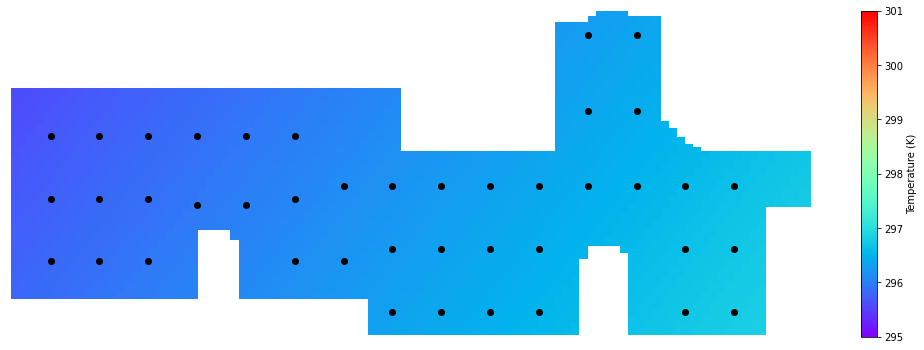

In [351]:
fig, ax=plt.subplots(1,1,figsize=(18,6))
im=ax.pcolormesh(*xgrid, ygrid, shading='auto', cmap='rainbow', vmin=295, vmax=301)
im_m=ax.plot(x, y, "ok", label="input point")

ax.set_xlim(-0.5,73.55)
ax.set_ylim(-3,22.95)
cbar=fig.colorbar(im, orientation='vertical', label='Temperature (K)')

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axis('off')

In [352]:
env.request_evauation_template()

In [353]:
template=pd.read_csv('D:/Research Working Folder/Paper_1-Mobile Sensing Virtual Environment/Template_demo_Dyna_2.csv')

X=template.iloc[:,1].values
Y=template.iloc[:,2].values

nor_X=np.zeros(len(template))
nor_Y=np.zeros(len(template))

for i in range(2):
    nor_X[:]=(X[:]-measurement_log[:,i].min())/(measurement_log[:,i].max()-measurement_log[:,i].min())
    nor_Y[:]=(Y[:]-measurement_log[:,i].min())/(measurement_log[:,i].max()-measurement_log[:,i].min())



Z=fglobal[1]+reg.intercept_+reg.coef_[0]*nor_X[:]+reg.coef_[1]*nor_Y[:]+reg.coef_[2]*nor_xflat[0,2]


for i in range(len(template)):
    template.iloc[i,3]=Z[i]

template.to_csv('D:/Research Working Folder/Paper_1-Mobile Sensing Virtual Environment/Template_demo_Dyna_2.csv', index=0)

env.compute_accuracy()

1.6652524294501552

In [354]:
len(action_series_df)

42

In [355]:
env.reset()


measurement_log=np.zeros(((len(action_series_df)-21+1),4))
measurement_log[0,:]=env.obs[:]

for i in range(len(action_series_df)-21):
    env.step(action_series_df.iloc[i,:].values)
    measurement_log[i+1,:]=env.obs[:]

In [356]:
env.obs

array([ 3.95000000e+01, -1.00000000e+00,  1.06500000e+03,  2.96517853e+02])

In [357]:
env.global_time

1065.0

In [361]:
x=measurement_log[:,0]
y=measurement_log[:,1]

t=measurement_log[:, 2]
v=measurement_log[:, 3]

fglobal=loess_1d.loess_1d(x=t,y=v, xnew=t)

In [362]:
r_i=v-fglobal[1]

In [363]:
r_i

array([ 1.47979854, -0.23605704,  0.02298797,  0.11938298,  0.16987877,
       -0.14583084, -0.0782925 , -0.04554912, -0.19134862,  0.03544286,
       -0.02736705, -0.05189655,  0.00183713, -0.02518005,  0.01331665,
       -0.06264775, -0.35575138, -0.02618343,  0.1306815 , -0.16991717,
        0.25654401, -0.07525326])

In [364]:
nor_measurement_log=np.zeros((22,3))
for i in range(3):
    nor_measurement_log[:,i]=(measurement_log[:,i]-measurement_log[:,i].min())/(measurement_log[:,i].max()-measurement_log[:,i].min())

In [365]:
reg=linear_model.LinearRegression()
reg.fit(nor_measurement_log[:, 0:3], r_i)

LinearRegression()

In [366]:
target_time=1065

xgrid=np.mgrid[-0.5:73.55:100j, -3:22.95:100j]
xflat = xgrid.reshape(2, -1).T
t_array=np.zeros((10000,1))+target_time
xflat=np.concatenate([xflat, t_array], axis=1)

nor_xflat=np.zeros((10000,3))
for i in range(3):
    nor_xflat[:,i]=(xflat[:,i]-measurement_log[:,i].min())/(measurement_log[:,i].max()-measurement_log[:,i].min())
    

fglobal=loess_1d.loess_1d(x=t,y=v, xnew=np.array([target_time]))

newz=fglobal[1]+reg.intercept_+reg.coef_[0]*nor_xflat[:,0]+reg.coef_[1]*nor_xflat[:,1]+reg.coef_[2]*nor_xflat[:,2]

In [367]:
data=env.stdata[['X', 'Y']]

delta=1.5

for i in range(10000):
    bb=xflat[i,:]
    judge_array=[0,0,0,0]
    window_data=data.loc[(data['X']>(bb[0]-delta)) & (data['X']<(bb[0]+delta)) & 
    (data['Y']>(bb[1]-delta)) & (data['Y']<(bb[1]+delta)), ['X', 'Y']]
    judge_array[0]=window_data.loc[(window_data['X']<bb[0]) & (window_data['Y']<bb[1])].empty
    judge_array[1]=window_data.loc[(window_data['X']<bb[0]) & (window_data['Y']>bb[1])].empty
    judge_array[2]=window_data.loc[(window_data['X']>bb[0]) & (window_data['Y']<bb[1])].empty
    judge_array[3]=window_data.loc[(window_data['X']>bb[0]) & (window_data['Y']>bb[1])].empty
    if True in judge_array:
        newz[i]=np.nan 


ygrid = newz.reshape(100, 100)

(-0.5, 73.55, -3.0, 22.95)

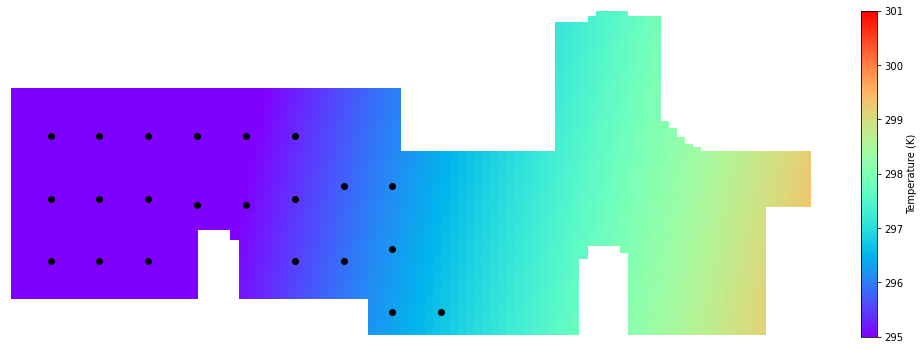

In [368]:
fig, ax=plt.subplots(1,1,figsize=(18,6))
im=ax.pcolormesh(*xgrid, ygrid, shading='auto', cmap='rainbow', vmin=295, vmax=301)
im_m=ax.plot(x, y, "ok", label="input point")

ax.set_xlim(-0.5,73.55)
ax.set_ylim(-3,22.95)
cbar=fig.colorbar(im, orientation='vertical', label='Temperature (K)')

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axis('off')

In [369]:
env.request_evauation_template()

In [370]:
template=pd.read_csv('D:/Research Working Folder/Paper_1-Mobile Sensing Virtual Environment/Template_demo_Dyna_1.csv')

X=template.iloc[:,1].values
Y=template.iloc[:,2].values

nor_X=np.zeros(len(template))
nor_Y=np.zeros(len(template))

for i in range(2):
    nor_X[:]=(X[:]-measurement_log[:,i].min())/(measurement_log[:,i].max()-measurement_log[:,i].min())
    nor_Y[:]=(Y[:]-measurement_log[:,i].min())/(measurement_log[:,i].max()-measurement_log[:,i].min())



Z=fglobal[1]+reg.intercept_+reg.coef_[0]*nor_X[:]+reg.coef_[1]*nor_Y[:]+reg.coef_[2]*nor_xflat[0,2]


for i in range(len(template)):
    template.iloc[i,3]=Z[i]

template.to_csv('D:/Research Working Folder/Paper_1-Mobile Sensing Virtual Environment/Template_demo_Dyna_1.csv', index=0)

env.compute_accuracy()

7.231274023701166

In [187]:
reg=linear_model.Ridge(alpha=0.5)
reg.fit(nor_measurement_log[:-1, 0:3], r_i)

Ridge(alpha=0.5)

In [188]:
reg.coef_

array([-0.08645918, -0.24755356, -0.11226996])

In [189]:
reg.intercept_

0.1967564697873432

In [190]:
target_time=2000

xgrid=np.mgrid[-0.5:73.55:100j, -3:22.95:100j]
xflat = xgrid.reshape(2, -1).T
t_array=np.zeros((10000,1))+target_time
xflat=np.concatenate([xflat, t_array], axis=1)

nor_xflat=np.zeros((10000,3))
for i in range(3):
    nor_xflat[:,i]=(xflat[:,i]-measurement_log[:,i].min())/(measurement_log[:,i].max()-measurement_log[:,i].min())
    

fglobal=loess_1d.loess_1d(x=t,y=v, xnew=np.array([target_time]))

newz=fglobal[1]+reg.intercept_+reg.coef_[0]*nor_xflat[:,0]+reg.coef_[1]*nor_xflat[:,1]+reg.coef_[2]*nor_xflat[:,2]

In [191]:
data=env.stdata[['X', 'Y']]

delta=1.5

for i in range(10000):
    bb=xflat[i,:]
    judge_array=[0,0,0,0]
    window_data=data.loc[(data['X']>(bb[0]-delta)) & (data['X']<(bb[0]+delta)) & 
    (data['Y']>(bb[1]-delta)) & (data['Y']<(bb[1]+delta)), ['X', 'Y']]
    judge_array[0]=window_data.loc[(window_data['X']<bb[0]) & (window_data['Y']<bb[1])].empty
    judge_array[1]=window_data.loc[(window_data['X']<bb[0]) & (window_data['Y']>bb[1])].empty
    judge_array[2]=window_data.loc[(window_data['X']>bb[0]) & (window_data['Y']<bb[1])].empty
    judge_array[3]=window_data.loc[(window_data['X']>bb[0]) & (window_data['Y']>bb[1])].empty
    if True in judge_array:
        newz[i]=np.nan 


ygrid = newz.reshape(100, 100)

(-0.5, 73.55, -3.0, 22.95)

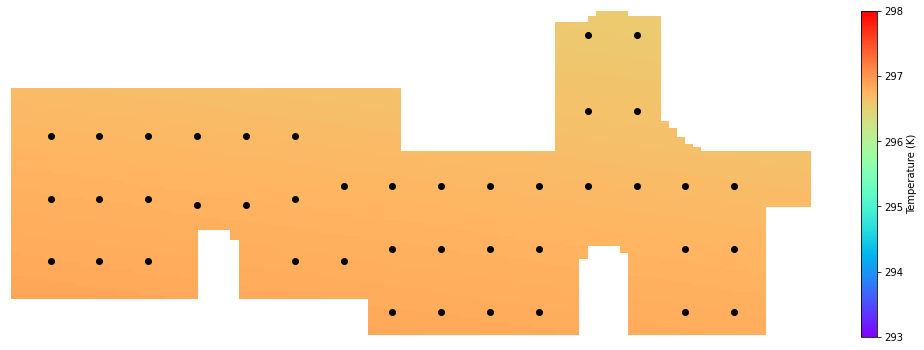

In [198]:
fig, ax=plt.subplots(1,1,figsize=(18,6))
im=ax.pcolormesh(*xgrid, ygrid, shading='auto', cmap='rainbow', vmin=293, vmax=298)
im_m=ax.plot(x, y, "ok", label="input point")

ax.set_xlim(-0.5,73.55)
ax.set_ylim(-3,22.95)
cbar=fig.colorbar(im, orientation='vertical', label='Temperature (K)')

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axis('off')

In [193]:
env.request_evauation_template()

In [194]:
template=pd.read_csv('D:/Research Working Folder/Paper_1-Mobile Sensing Virtual Environment/Template_demo_Dyna_2.csv')

X=template.iloc[:,1].values
Y=template.iloc[:,2].values

nor_X=np.zeros(len(template))
nor_Y=np.zeros(len(template))

for i in range(2):
    nor_X[:]=(X[:]-measurement_log[:,i].min())/(measurement_log[:,i].max()-measurement_log[:,i].min())
    nor_Y[:]=(Y[:]-measurement_log[:,i].min())/(measurement_log[:,i].max()-measurement_log[:,i].min())



Z=fglobal[1]+reg.intercept_+reg.coef_[0]*nor_X[:]+reg.coef_[1]*nor_Y[:]+reg.coef_[2]*nor_xflat[0,2]


for i in range(len(template)):
    template.iloc[i,3]=Z[i]

template.to_csv('D:/Research Working Folder/Paper_1-Mobile Sensing Virtual Environment/Template_demo_Dyna_2.csv', index=0)

env.compute_accuracy()

0.9169303521302516

In [199]:
from sklearn import svm

In [217]:
regr=svm.SVR()
regr.fit(nor_measurement_log[:-1, 0:3], r_i)

target_time=2000

xgrid=np.mgrid[-0.5:73.55:100j, -3:22.95:100j]
xflat = xgrid.reshape(2, -1).T
t_array=np.zeros((10000,1))+target_time
xflat=np.concatenate([xflat, t_array], axis=1)

nor_xflat=np.zeros((10000,3))
for i in range(3):
    nor_xflat[:,i]=(xflat[:,i]-measurement_log[:,i].min())/(measurement_log[:,i].max()-measurement_log[:,i].min())
    

fglobal=loess_1d.loess_1d(x=t,y=v, xnew=np.array([target_time]))

newz=regr.predict(nor_xflat)+fglobal[1]

In [219]:
newz.max()

296.92053990036516

In [210]:
data=env.stdata[['X', 'Y']]

delta=1.5

for i in range(10000):
    bb=xflat[i,:]
    judge_array=[0,0,0,0]
    window_data=data.loc[(data['X']>(bb[0]-delta)) & (data['X']<(bb[0]+delta)) & 
    (data['Y']>(bb[1]-delta)) & (data['Y']<(bb[1]+delta)), ['X', 'Y']]
    judge_array[0]=window_data.loc[(window_data['X']<bb[0]) & (window_data['Y']<bb[1])].empty
    judge_array[1]=window_data.loc[(window_data['X']<bb[0]) & (window_data['Y']>bb[1])].empty
    judge_array[2]=window_data.loc[(window_data['X']>bb[0]) & (window_data['Y']<bb[1])].empty
    judge_array[3]=window_data.loc[(window_data['X']>bb[0]) & (window_data['Y']>bb[1])].empty
    if True in judge_array:
        newz[i]=np.nan 


ygrid = newz.reshape(100, 100)

(-0.5, 73.55, -3.0, 22.95)

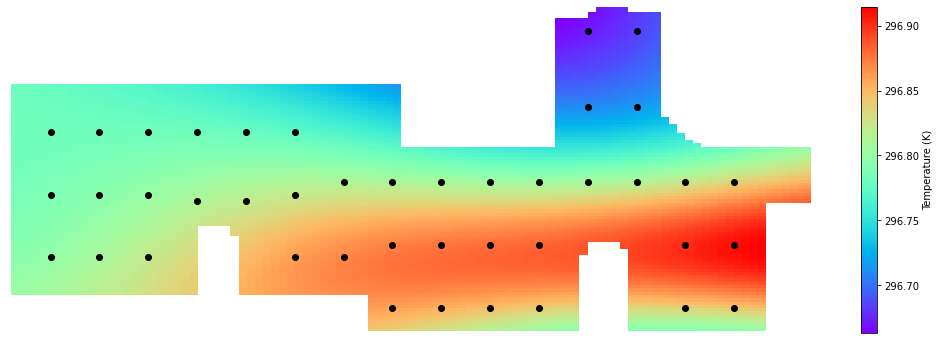

In [216]:
fig, ax=plt.subplots(1,1,figsize=(18,6))
im=ax.pcolormesh(*xgrid, ygrid, shading='auto', cmap='rainbow')
im_m=ax.plot(x, y, "ok", label="input point")

ax.set_xlim(-0.5,73.55)
ax.set_ylim(-3,22.95)
cbar=fig.colorbar(im, orientation='vertical', label='Temperature (K)')

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axis('off')

In [220]:
from sklearn.neighbors import KNeighborsRegressor

In [247]:
neigh = KNeighborsRegressor(n_neighbors=5, weights='distance')


neigh.fit(nor_measurement_log[:-1, 0:3], r_i)

target_time=2000

xgrid=np.mgrid[-0.5:73.55:100j, -3:22.95:100j]
xflat = xgrid.reshape(2, -1).T
t_array=np.zeros((10000,1))+target_time
xflat=np.concatenate([xflat, t_array], axis=1)

nor_xflat=np.zeros((10000,3))
for i in range(3):
    nor_xflat[:,i]=(xflat[:,i]-measurement_log[:,i].min())/(measurement_log[:,i].max()-measurement_log[:,i].min())
    

fglobal=loess_1d.loess_1d(x=t,y=v, xnew=np.array([target_time]))

newz=neigh.predict(nor_xflat)+fglobal[1]



In [248]:
data=env.stdata[['X', 'Y']]

delta=1.5

for i in range(10000):
    bb=xflat[i,:]
    judge_array=[0,0,0,0]
    window_data=data.loc[(data['X']>(bb[0]-delta)) & (data['X']<(bb[0]+delta)) & 
    (data['Y']>(bb[1]-delta)) & (data['Y']<(bb[1]+delta)), ['X', 'Y']]
    judge_array[0]=window_data.loc[(window_data['X']<bb[0]) & (window_data['Y']<bb[1])].empty
    judge_array[1]=window_data.loc[(window_data['X']<bb[0]) & (window_data['Y']>bb[1])].empty
    judge_array[2]=window_data.loc[(window_data['X']>bb[0]) & (window_data['Y']<bb[1])].empty
    judge_array[3]=window_data.loc[(window_data['X']>bb[0]) & (window_data['Y']>bb[1])].empty
    if True in judge_array:
        newz[i]=np.nan 


ygrid = newz.reshape(100, 100)

(-0.5, 73.55, -3.0, 22.95)

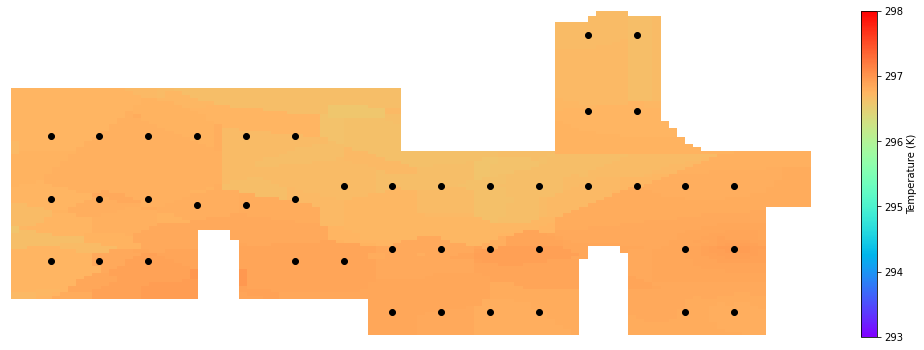

In [250]:
fig, ax=plt.subplots(1,1,figsize=(18,6))
im=ax.pcolormesh(*xgrid, ygrid, shading='auto', cmap='rainbow', vmin=293, vmax=298)
im_m=ax.plot(x, y, "ok", label="input point")

ax.set_xlim(-0.5,73.55)
ax.set_ylim(-3,22.95)
cbar=fig.colorbar(im, orientation='vertical', label='Temperature (K)')

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axis('off')

In [251]:
env.request_evauation_template()

In [252]:
template=pd.read_csv('D:/Research Working Folder/Paper_1-Mobile Sensing Virtual Environment/Template_demo_Dyna_3.csv')

X=template.iloc[:,1].values
Y=template.iloc[:,2].values

nor_X=np.zeros(len(template))
nor_Y=np.zeros(len(template))

for i in range(2):
    nor_X[:]=(X[:]-measurement_log[:,i].min())/(measurement_log[:,i].max()-measurement_log[:,i].min())
    nor_Y[:]=(Y[:]-measurement_log[:,i].min())/(measurement_log[:,i].max()-measurement_log[:,i].min())



Z=fglobal[1]+reg.intercept_+reg.coef_[0]*nor_X[:]+reg.coef_[1]*nor_Y[:]+reg.coef_[2]*nor_xflat[0,2]


for i in range(len(template)):
    template.iloc[i,3]=Z[i]

template.to_csv('D:/Research Working Folder/Paper_1-Mobile Sensing Virtual Environment/Template_demo_Dyna_3.csv', index=0)

env.compute_accuracy()

1.0223045828612034

In [262]:
from sklearn.ensemble import AdaBoostRegressor

In [275]:
regr = AdaBoostRegressor(random_state=0, n_estimators=100)

#regr.fit(nor_measurement_log[:-1, 0:3], r_i)
regr.fit(measurement_log[:-1, 0:3], r_i)


target_time=2000

xgrid=np.mgrid[-0.5:73.55:100j, -3:22.95:100j]
xflat = xgrid.reshape(2, -1).T
t_array=np.zeros((10000,1))+target_time
xflat=np.concatenate([xflat, t_array], axis=1)

#nor_xflat=np.zeros((10000,3))
#for i in range(3):
    #nor_xflat[:,i]=(xflat[:,i]-measurement_log[:,i].min())/(measurement_log[:,i].max()-measurement_log[:,i].min())
    

fglobal=loess_1d.loess_1d(x=t,y=v, xnew=np.array([target_time]))

#newz=regr.predict(nor_xflat)+fglobal[1]
newz=regr.predict(xflat)+fglobal[1]

In [276]:
regr.score(nor_measurement_log[:-1, 0:3], r_i)

-28.095920572722363

In [278]:
measurement_log

array([[ 3.50000000e+00,  3.00000000e+00,  0.00000000e+00,
         3.00000000e+02],
       [ 3.50000000e+00,  8.00000000e+00,  4.00000000e+01,
         2.98157501e+02],
       [ 3.50000000e+00,  1.30000000e+01,  8.00000000e+01,
         2.98247864e+02],
       [ 8.00000000e+00,  1.30000000e+01,  1.40000000e+02,
         2.98019958e+02],
       [ 8.00000000e+00,  8.00000000e+00,  1.80000000e+02,
         2.97893524e+02],
       [ 8.00000000e+00,  3.00000000e+00,  2.20000000e+02,
         2.97400238e+02],
       [ 1.25000000e+01,  3.00000000e+00,  2.80000000e+02,
         2.97206207e+02],
       [ 1.25000000e+01,  8.00000000e+00,  3.20000000e+02,
         2.97086334e+02],
       [ 1.25000000e+01,  1.30000000e+01,  3.60000000e+02,
         2.96796326e+02],
       [ 1.70000000e+01,  1.30000000e+01,  4.20000000e+02,
         2.96851013e+02],
       [ 1.70000000e+01,  7.50000000e+00,  4.90000000e+02,
         2.96633789e+02],
       [ 2.15000000e+01,  7.50000000e+00,  5.50000000e+02,
      

In [268]:
data=env.stdata[['X', 'Y']]

delta=1.5

for i in range(10000):
    bb=xflat[i,:]
    judge_array=[0,0,0,0]
    window_data=data.loc[(data['X']>(bb[0]-delta)) & (data['X']<(bb[0]+delta)) & 
    (data['Y']>(bb[1]-delta)) & (data['Y']<(bb[1]+delta)), ['X', 'Y']]
    judge_array[0]=window_data.loc[(window_data['X']<bb[0]) & (window_data['Y']<bb[1])].empty
    judge_array[1]=window_data.loc[(window_data['X']<bb[0]) & (window_data['Y']>bb[1])].empty
    judge_array[2]=window_data.loc[(window_data['X']>bb[0]) & (window_data['Y']<bb[1])].empty
    judge_array[3]=window_data.loc[(window_data['X']>bb[0]) & (window_data['Y']>bb[1])].empty
    if True in judge_array:
        newz[i]=np.nan 


ygrid = newz.reshape(100, 100)

(-0.5, 73.55, -3.0, 22.95)

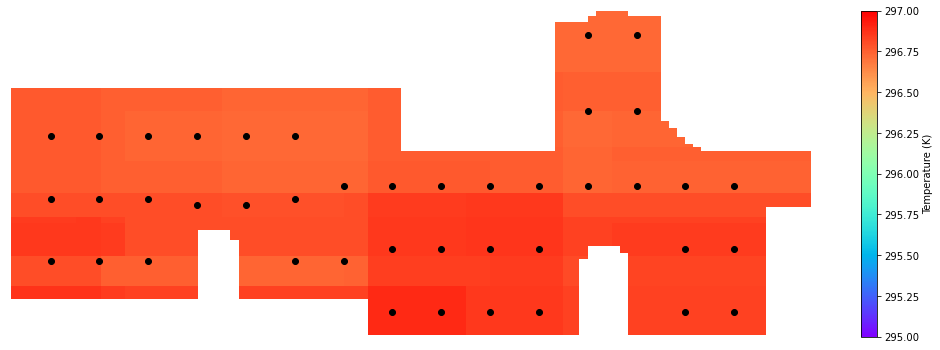

In [271]:
fig, ax=plt.subplots(1,1,figsize=(18,6))
im=ax.pcolormesh(*xgrid, ygrid, shading='auto', cmap='rainbow', vmin=295, vmax=297)
im_m=ax.plot(x, y, "ok", label="input point")

ax.set_xlim(-0.5,73.55)
ax.set_ylim(-3,22.95)
cbar=fig.colorbar(im, orientation='vertical', label='Temperature (K)')

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axis('off')

In [279]:
from sklearn.ensemble import RandomForestRegressor

In [285]:
regr = RandomForestRegressor(random_state=0)

regr.fit(nor_measurement_log[:-1, 0:3], r_i)
#regr.fit(measurement_log[:-1, 0:3], r_i)


target_time=2000

xgrid=np.mgrid[-0.5:73.55:100j, -3:22.95:100j]
xflat = xgrid.reshape(2, -1).T
t_array=np.zeros((10000,1))+target_time
xflat=np.concatenate([xflat, t_array], axis=1)

nor_xflat=np.zeros((10000,3))
for i in range(3):
    nor_xflat[:,i]=(xflat[:,i]-measurement_log[:,i].min())/(measurement_log[:,i].max()-measurement_log[:,i].min())
    

fglobal=loess_1d.loess_1d(x=t,y=v, xnew=np.array([target_time]))

newz=regr.predict(nor_xflat)+fglobal[1]
#newz=regr.predict(xflat)+fglobal[1]

In [286]:
data=env.stdata[['X', 'Y']]

delta=1.5

for i in range(10000):
    bb=xflat[i,:]
    judge_array=[0,0,0,0]
    window_data=data.loc[(data['X']>(bb[0]-delta)) & (data['X']<(bb[0]+delta)) & 
    (data['Y']>(bb[1]-delta)) & (data['Y']<(bb[1]+delta)), ['X', 'Y']]
    judge_array[0]=window_data.loc[(window_data['X']<bb[0]) & (window_data['Y']<bb[1])].empty
    judge_array[1]=window_data.loc[(window_data['X']<bb[0]) & (window_data['Y']>bb[1])].empty
    judge_array[2]=window_data.loc[(window_data['X']>bb[0]) & (window_data['Y']<bb[1])].empty
    judge_array[3]=window_data.loc[(window_data['X']>bb[0]) & (window_data['Y']>bb[1])].empty
    if True in judge_array:
        newz[i]=np.nan 


ygrid = newz.reshape(100, 100)

(-0.5, 73.55, -3.0, 22.95)

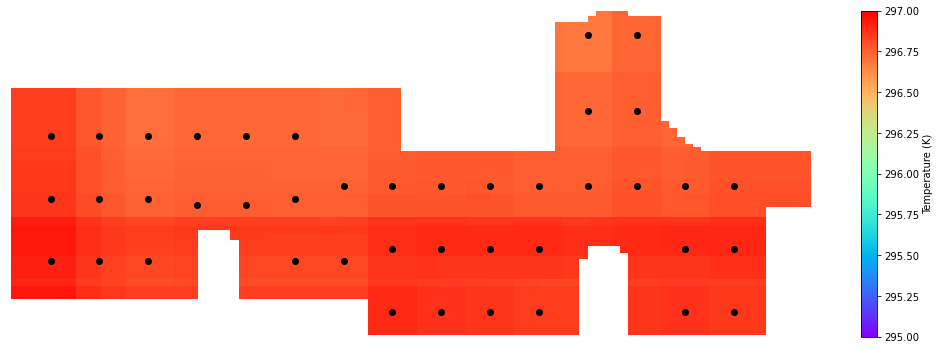

In [287]:
fig, ax=plt.subplots(1,1,figsize=(18,6))
im=ax.pcolormesh(*xgrid, ygrid, shading='auto', cmap='rainbow', vmin=295, vmax=297)
im_m=ax.plot(x, y, "ok", label="input point")

ax.set_xlim(-0.5,73.55)
ax.set_ylim(-3,22.95)
cbar=fig.colorbar(im, orientation='vertical', label='Temperature (K)')

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axis('off')

In [166]:
reg=linear_model.Lasso(alpha=0.5)
reg.fit(nor_measurement_log[:-1, 0:3], r_i)
target_time=2000

xgrid=np.mgrid[-0.5:73.55:100j, -3:22.95:100j]
xflat = xgrid.reshape(2, -1).T
t_array=np.zeros((10000,1))+target_time
xflat=np.concatenate([xflat, t_array], axis=1)

nor_xflat=np.zeros((10000,3))
for i in range(3):
    nor_xflat[:,i]=(xflat[:,i]-measurement_log[:,i].min())/(measurement_log[:,i].max()-measurement_log[:,i].min())
    

fglobal=loess_1d.loess_1d(x=t,y=v, xnew=np.array([target_time]))

newz=reg.predict(nor_xflat)+fglobal[1]


In [168]:
reg.predict(nor_xflat)

array([0.00092161, 0.00092161, 0.00092161, ..., 0.00092161, 0.00092161,
       0.00092161])

In [299]:
nor_xflat

array([[-0.06349206, -0.09090909,  0.99750623],
       [-0.06349206, -0.07899449,  0.99750623],
       [-0.06349206, -0.06707989,  0.99750623],
       ...,
       [ 1.11190476,  1.06480716,  0.99750623],
       [ 1.11190476,  1.07672176,  0.99750623],
       [ 1.11190476,  1.08863636,  0.99750623]])

In [300]:
nor_measurement_log[:, 0:3]

array([[0.        , 0.18181818, 0.        ],
       [0.        , 0.40909091, 0.01995012],
       [0.        , 0.63636364, 0.03990025],
       [0.07142857, 0.63636364, 0.06982544],
       [0.07142857, 0.40909091, 0.08977556],
       [0.07142857, 0.18181818, 0.10972569],
       [0.14285714, 0.18181818, 0.13965087],
       [0.14285714, 0.40909091, 0.159601  ],
       [0.14285714, 0.63636364, 0.17955112],
       [0.21428571, 0.63636364, 0.20947631],
       [0.21428571, 0.38636364, 0.24438903],
       [0.28571429, 0.38636364, 0.27431421],
       [0.28571429, 0.63636364, 0.30922693],
       [0.35714286, 0.63636364, 0.33915212],
       [0.35714286, 0.40909091, 0.35910224],
       [0.35714286, 0.18181818, 0.37905237],
       [0.42857143, 0.18181818, 0.40897756],
       [0.42857143, 0.45454545, 0.43142145],
       [0.5       , 0.45454545, 0.46134663],
       [0.5       , 0.22727273, 0.48129676],
       [0.5       , 0.        , 0.50124688],
       [0.57142857, 0.        , 0.53117207],
       [0.

In [289]:
data=env.stdata[['X', 'Y']]

delta=1.5

for i in range(10000):
    bb=xflat[i,:]
    judge_array=[0,0,0,0]
    window_data=data.loc[(data['X']>(bb[0]-delta)) & (data['X']<(bb[0]+delta)) & 
    (data['Y']>(bb[1]-delta)) & (data['Y']<(bb[1]+delta)), ['X', 'Y']]
    judge_array[0]=window_data.loc[(window_data['X']<bb[0]) & (window_data['Y']<bb[1])].empty
    judge_array[1]=window_data.loc[(window_data['X']<bb[0]) & (window_data['Y']>bb[1])].empty
    judge_array[2]=window_data.loc[(window_data['X']>bb[0]) & (window_data['Y']<bb[1])].empty
    judge_array[3]=window_data.loc[(window_data['X']>bb[0]) & (window_data['Y']>bb[1])].empty
    if True in judge_array:
        newz[i]=np.nan 


ygrid = newz.reshape(100, 100)

(-0.5, 73.55, -3.0, 22.95)

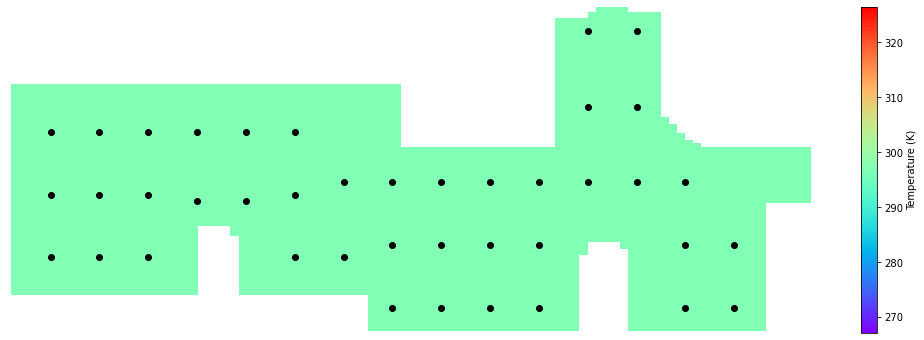

In [293]:
fig, ax=plt.subplots(1,1,figsize=(18,6))
im=ax.pcolormesh(*xgrid, ygrid, shading='auto', cmap='rainbow')
im_m=ax.plot(x, y, "ok", label="input point")

ax.set_xlim(-0.5,73.55)
ax.set_ylim(-3,22.95)
cbar=fig.colorbar(im, orientation='vertical', label='Temperature (K)')

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axis('off')